In [1]:
from keras import backend as K
#import ktrain
import keras
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### Loading and Pre-Processing the Data:

Some details about the dataset:

- Name : Cifar10
- Number of classes : 10
- Training set size : 50K
- Test set size : 10K
- Image resolution : 32x32

In the code below, we :

- Load the data extracted from a tar.gz file into python variables *(train_features, test_features , test_labels and train_labels)*
- Each of the images are in shape *[3, 32, 32]* and labels are simple integers


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

###Looking at a few examples :

In the code below, we :

- Decode the int labels into class names using a python list

Then for each of our classes we do the following:
- Add a subplot to the figure
- Find the first image in the trainset with that label 
- Plot that image to the subplot
- Set the class name as the title of the subplot

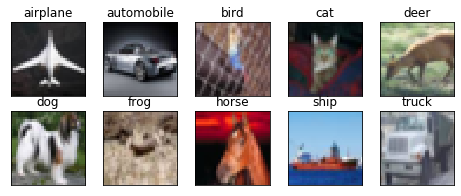

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Plotting model history:

In the code below, we define a utility function that takes the history returned by the *fit_generator()* function and plots the record of the accuracies and losses:

- Plot the train and test accuracies recorded after every epoch
- Plot the train and test losses recorded after every epoch


In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

###Getting the accuracy:

The code below defines a utility function that calculates the accuracy given:

- Training Images of shape *(batch_size, height, width, num_channels)*
- Training labels of shape *(batch_size, num_classes)*
- Returns accuracy in percentage


In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

###Processing the data:

We do the following in the code below:

- Convert image matrices to float
- Encode the labels in a One hot format

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

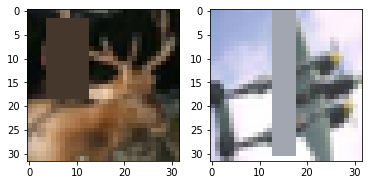

In [9]:
def get_cutout_fn(min_area_ratio, max_area_ratio):
  area_ratio = np.random.uniform(min_area_ratio, max_area_ratio)
  def cutout(X):
    
    H, W, C = X.shape
    
    img_area = H*W
    cutout_area = img_area * area_ratio
    
    
    max_aspect_ratio = max([(H*H)/cutout_area,cutout_area/(W*W)])
    min_aspect_ratio = min([(H*H)/cutout_area,cutout_area/(W*W)])
    
    aspect_ratio = np.random.uniform(min_aspect_ratio, max_aspect_ratio)
    
    cutout_width = int(np.ceil(np.sqrt(cutout_area/aspect_ratio)))
    cutout_height = int(np.ceil(np.sqrt(cutout_area*aspect_ratio)))
    
    if cutout_height == 32:
      top = 0
    else:
      top = np.random.randint(0, H - cutout_height)  
    
    if cutout_width == 32:
      left = 0
    else:
      left = np.random.randint(0, W - cutout_width)
    
    for c in range(C):
      mu = np.mean(X[top:top + cutout_height, left:left + cutout_width, c])
      X[top:top + cutout_height, left: left + cutout_width, c] = mu
      
      
    return X
    
    
  return cutout

cutout_fn = get_cutout_fn(0.1, 0.3)
fig, ax = plt.subplots(1,2)
ax[0].imshow(cutout_fn(train_features[3465]))
ax[1].imshow(cutout_fn(train_features[3466]))

In [0]:
# Define the model
def get_model():
  model1 = Sequential()
  model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.2))

  model1.add(Convolution2D(32, 1, 1))


  model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.3))

  model1.add(Convolution2D(32, 1, 1))


  model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.5))

  model1.add(Convolution2D(10, 1, 1))

  model1.add(AveragePooling2D(pool_size = (4,4)))
  model1.add(Flatten())


  model1.add(Activation('softmax'))

  return model1



In [11]:
model = get_model()
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to th


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`


###Finding the best Learning Rate:

Alright! Now we are truly at the crux of the assignment. We do the following below to find the best learning rate.

- We declare a class called *LR_Finder* that inherits from the keras class *Callback*
- This is an Abstract class that when inherited needs one or many of the following functions to be over-ridden:
  - on_batch_end
  - on_batch_begin
  - on_epoch_end
  - on_epoch_begin
  - on_train_begin
  
- As you can see, we have over-ridden the implementations of *on_train_begin* and *on_batch_end*
- We do the following on every batch end:
  - Increase the LR of the optimizer exponentially
  - Store the loss and the smoothened loss values in separate arrays
  - Store the current LR to an array
  - *Beta* is the smoothening factor that kind of works like momentum in this case
  - We also check if the current loss has surpassed the best loss by a pre-defined factor - If so - we stop training
- Next, we provide various plotting utilities to plot the loss / smoothened loss against the LRs / iterations

In [0]:
class LR_Finder(keras.callbacks.Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip_beg=10, n_skip_end = 5):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip_beg:-n_skip_end], self.losses[n_skip_beg:-n_skip_end])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip_beg=10, n_skip_end = 10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip_beg:-n_skip_end], self.smoothed_losses[n_skip_beg:-n_skip_end])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

###Training with our callback:

- We declare our LR_Finder as the variable LRF
- We get and compile the model with SGD using momentum of 0.5 and using our callback to store losses and increase LRs

In [0]:
from keras.callbacks import ModelCheckpoint

train_datagen = ImageDataGenerator(featurewise_center = True, 
                                   featurewise_std_normalization = True,
                                   rotation_range = 10,
                                   zoom_range = 0.10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   preprocessing_function = get_cutout_fn(0.1, 0.3))
test_datagen = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
train_datagen.fit(train_features)
test_datagen.fit(test_features)

train_data_iter = train_datagen.flow(train_features,train_labels, batch_size = 128)
test_data_iter =  test_datagen.flow(test_features,test_labels, batch_size = 10000)

CKPT = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max', period=1)
LRF = LR_Finder(step_size = np.ceil(50000/128))


In [14]:
model = get_model()
optim = keras.optimizers.SGD(lr=0.005, momentum=0.5, nesterov=False)
model.compile(optimizer = optim, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(train_data_iter,
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = test_data_iter.next(), verbose=1, callbacks = [CKPT, LRF])
end = time.time()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), ke

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  # Remove the CWD from sys.path while we load stuff.




Epoch 1/100
390/390 [==============================] - 53s 136ms/step - loss: 3.4909 - acc: 0.1916 - val_loss: 14.7034 - val_acc: 0.0997
Epoch 2/100
  3/390 [..............................] - ETA: 46s - loss: 14.7978 - acc: 0.0938

###Plotting results:

- Now that our model has stopped training due to our *stop_loss* criterion, we can plot the losses and LRs. The plots below are the following:
  - Losses Vs LR
  - Smoothened Losses Vs LR
  - LR Vs Iteration


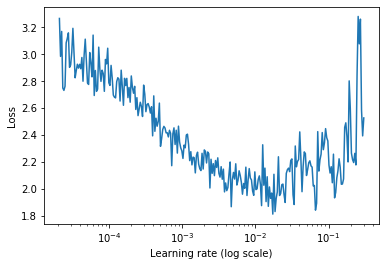

In [15]:
LRF.plot(20, 100)

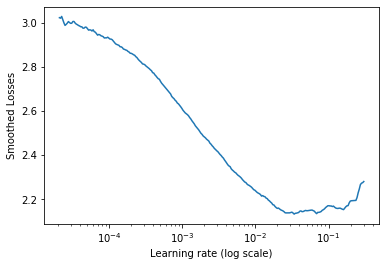

In [16]:
LRF.plot_smoothed_loss(20, 100)

*We observe that the suitable learing rate is around 0.05

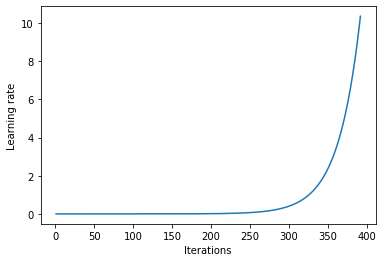

In [17]:
LRF.plot_lr()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), ke

Starting training for 100 epochs


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  # This is added back by InteractiveShellApp.init_path()


Model took 4567.19 seconds to train


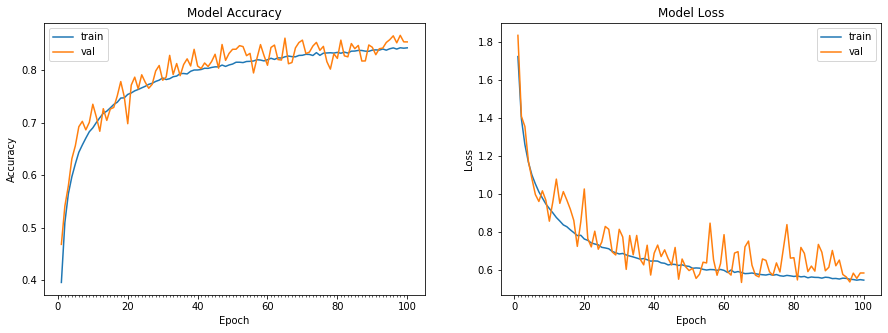

Accuracy on test data is: 86.64


In [18]:
model = get_model()
optim = keras.optimizers.SGD(lr=0.05, momentum=0.5, nesterov=False)
model.compile(optimizer = optim, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
start = time.time()
# Train the model
print("Starting training for 100 epochs")
model_info = model.fit_generator(train_data_iter,
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = test_data_iter.next(), verbose=0, callbacks = [CKPT])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
plot_model_history(model_info)

model.load_weights('./best_model.hdf5')
test_features, test_labels = test_data_iter.next()
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [19]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)       

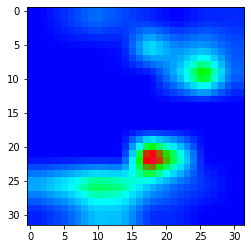

In [21]:
import cv2

def gradCAM(img, model, layer_name):
  class_idx = np.argmax(model.predict(img)[0])
  
  class_output = model.output[:, class_idx]
  layer = model.get_layer(layer_name)
  
  grads = K.gradients(class_output, layer.output)[0]
  pooled_grads = K.mean(grads, axis = (0, 1, 2))
  
  iterate = K.function([model.input],[pooled_grads, layer.output[0]])
  
  pooled_grads_val, layer_output_val = iterate([img])
  
  
  for i in range(pooled_grads_val.shape[0]):
    layer_output_val[:,:,i] *= pooled_grads_val[i]
  
  heatmap = np.sum(layer_output_val, axis = 2)
  heatmap = np.maximum(heatmap, 0)
  
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (32,32))
  heatmap = np.uint8(heatmap * 255)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
    
  return heatmap
  
  
  
plt.imshow(gradCAM(train_features[67].reshape([-1,32,32,3]), model, 'conv2d_24'))

### Plotting incorrectly classified images

In [0]:
(train_features_1, train_labels_1), (test_features_1, test_labels_1) = cifar10.load_data()
test_features_scaled = test_features_1.astype('float32')/255
test_labels_1 = np_utils.to_categorical(test_labels_1, num_classes)
test_datagen.fit(test_features_scaled)
#test_data_iter =  test_datagen.flow(test_features_scaled,test_labels_1, batch_size = 10000)
test_features = test_datagen.standardize(test_features_scaled)

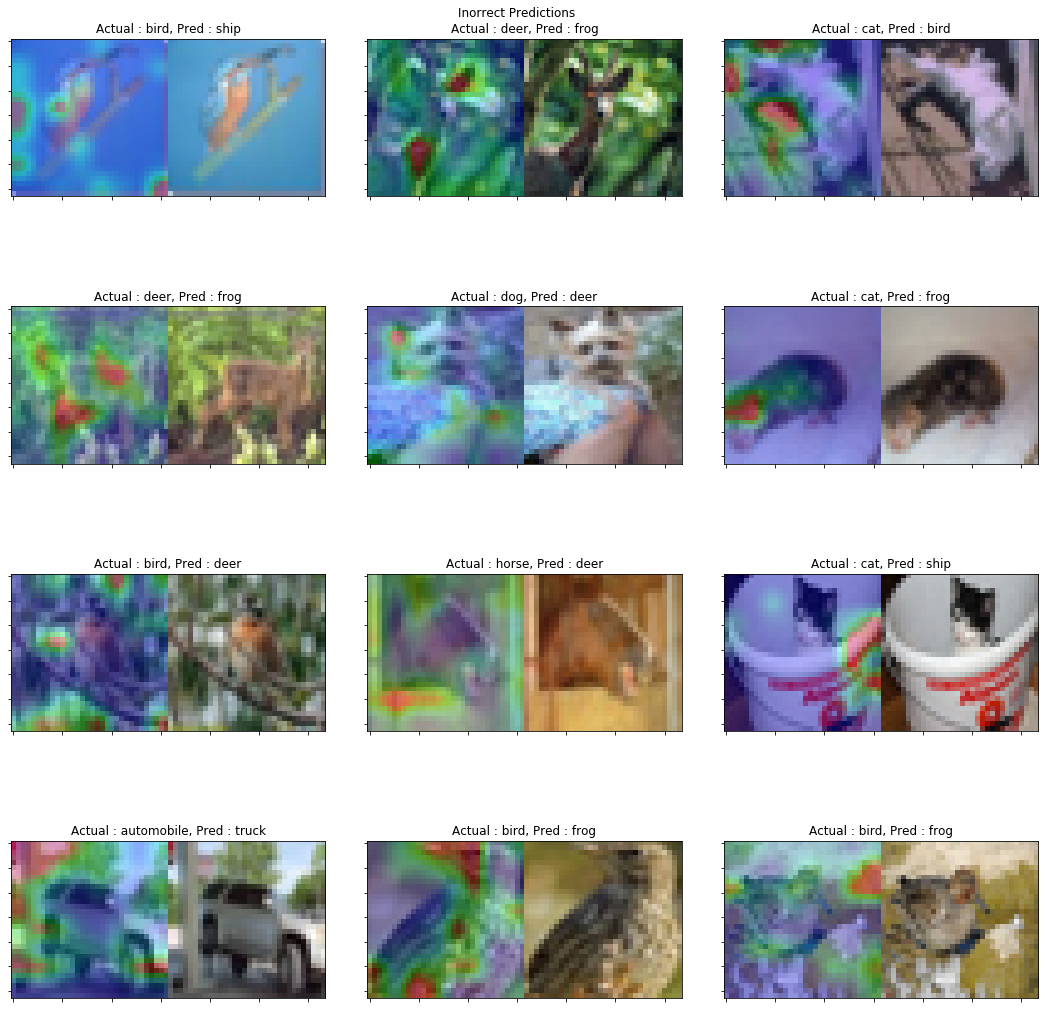

In [23]:
actuals = np.argmax(test_labels_1, axis = 1)
preds = np.argmax(model.predict(test_features), axis = 1)

correct_idx = [idx for idx in range(10000) if actuals[idx] == preds[idx]]
incorrect_idx = [idx for idx in range(10000) if idx not in correct_idx]

#correct_plot_idx = np.random.choice(correct_idx, size = 12, replace = False)
incorrect_plot_idx = np.random.choice(incorrect_idx, size = 12, replace = False)

fig, ax = plt.subplots(4,3, figsize = (15,15))
fig.tight_layout()
fig.suptitle("Inorrect Predictions")

plot_idx = 0

for i in range(4):
  for j in range(3):
    img = test_features[incorrect_plot_idx[plot_idx]].reshape([-1,32,32,3])
    
    unnormalized_img = test_features_1[incorrect_plot_idx[plot_idx]]
    
    heatmap = gradCAM(img, model, "conv2d_24")
    
    superimposed_img = cv2.addWeighted(unnormalized_img, 0.7, heatmap, 0.3, 0, dtype = cv2.CV_32F)/255
    
    true_class = class_names[actuals[incorrect_plot_idx[plot_idx]]]
    pred_class = class_names[preds[incorrect_plot_idx[plot_idx]]]
    plot_idx += 1
    plot_img = np.concatenate((superimposed_img, unnormalized_img/255), axis = 1)
    ax[i, j].imshow(plot_img)
    ax[i, j].set_xticklabels([])
    ax[i, j].set_yticklabels([])
    ax[i, j].set_title("Actual : {}, Pred : {}".format(true_class, pred_class))
